In [ ]:
# Type hints
from typing import Any, Dict, List, Tuple, Optional

# Standard library
import ast
import logging
import re
import warnings
import os

# Third-party packages - Data manipulation
import pandas as pd
from tqdm import tqdm

# Third-party packages - Environment & Database
from dotenv import load_dotenv
from neo4j import GraphDatabase

# Third-party packages - Error handling & Retry logic
from tenacity import retry, stop_after_attempt, wait_exponential

# Langchain - Core
from langchain.chains import GraphCypherQAChain
from langchain.prompts import PromptTemplate
from langchain_core.documents import Document

# Langchain - Models & Connectors
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI
from langchain_ollama.llms import OllamaLLM

# Langchain - Graph & Experimental
from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY") # if you are using Google API

False

In [21]:
movies = pd.read_csv('data/wiki_movie_plots_deduped.csv') # adjust the path if you manually downloaded the dataset
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [22]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and preprocess DataFrame.
    
    Args:
        data: Input DataFrame
        
    Returns:
        Cleaned DataFrame
    """
    df.drop(["Wiki Page"], axis=1, inplace=True)

    # Drop duplicates
    df = df.drop_duplicates(subset='Title', keep='first')
    
    # Get object columns
    col_obj = df.select_dtypes(include=["object"]).columns
    
    # Clean string columns
    for col in col_obj:
        # Strip whitespace
        df[col] = df[col].str.strip()
        
        # Replace unknown/empty values
        df[col] = df[col].apply(
            lambda x: None if pd.isna(x) or x.lower() in ["", "unknown"] 
            else x.capitalize()
        )
    
    # Drop rows with any null values
    df = df.dropna(how="any", axis=0)
    
    return df

movies = clean_data(movies).head(1000)
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Plot
13,1907,Daniel boone,American,Wallace mccutcheon and ediwin s. porter,"William craven, florence lawrence",Biographical,Boone's daughter befriends an indian maiden as...
15,1907,Laughing gas,American,Edwin stanton porter,"Bertha regustus, edward boulden",Comedy,The plot is that of a black woman going to the...
16,1908,The adventures of dollie,American,D. w. griffith,"Arthur v. johnson, linda arvidson",Drama,On a beautiful summer day a father and mother ...
17,1908,The black viper,American,D. w. griffith,D. w. griffith,Drama,A thug accosts a girl as she leaves her workpl...
18,1908,A calamitous elopement,American,D.w. griffith,"Harry solter, linda arvidson",Comedy,A young couple decides to elope after being ca...


# Connection to Neo4j database 

In [29]:
class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
        print("Connection closed")

    def reset_database(self):
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
            print("Database resetted successfully!")

    def execute_query(self, query, parameters=None):
        with self.driver.session() as session:
            result = session.run(query, parameters or {})
            return [record for record in result]

In [30]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "ultrassfaxiens2007"
conn = Neo4jConnection(uri, user, password)
conn.reset_database()

Database resetted successfully!


# Manual Building

In [31]:
def parse_number(value: Any, target_type: type) -> Optional[float]:
    """Parse string to number with proper error handling."""
    if pd.isna(value):
        return None
    try:
        cleaned = str(value).strip().replace(',', '')
        return target_type(cleaned)
    except (ValueError, TypeError):
        return None

def clean_text(text: str) -> str:
    """Clean and normalize text fields."""
    if pd.isna(text):
        return ""
    return str(text).strip().title()

In [32]:
def load_movies_to_neo4j(movies_df: pd.DataFrame, connection: GraphDatabase) -> None:
    """Load movie data into Neo4j with progress tracking and error handling."""
    
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    # Query templates
    MOVIE_QUERY = """
        MERGE (movie:Movie {title: $title})
        SET movie.year = $year,
            movie.origin = $origin,
            movie.genre = $genre,
            movie.plot = $plot
    """
    
    DIRECTOR_QUERY = """
        MATCH (movie:Movie {title: $title})
        MERGE (director:Director {name: $name})
        MERGE (director)-[:DIRECTED]->(movie)
    """
    
    ACTOR_QUERY = """
        MATCH (movie:Movie {title: $title})
        MERGE (actor:Actor {name: $name})
        MERGE (actor)-[:ACTED_IN]->(movie)
    """

    # Process each movie
    for _, row in tqdm(movies_df.iterrows(), total=len(movies_df), desc="Loading movies"):
        try:
            # Prepare movie parameters
            movie_params = {
                "title": clean_text(row["Title"]),
                "year": parse_number(row["Release Year"], int),
                "origin": clean_text(row["Origin/Ethnicity"]),
                "genre": clean_text(row["Genre"]),
                "plot": str(row["Plot"]).strip()
            }
            
            # Create movie node
            connection.execute_query(MOVIE_QUERY, parameters=movie_params)
            
            # Process directors
            for director in str(row["Director"]).split(" and "):
                director_params = {
                    "name": clean_text(director),
                    "title": movie_params["title"]
                }
                connection.execute_query(DIRECTOR_QUERY, parameters=director_params)
            
            # Process cast
            if pd.notna(row["Cast"]):
                for actor in row["Cast"].split(","):
                    actor_params = {
                        "name": clean_text(actor),
                        "title": movie_params["title"]
                    }
                    connection.execute_query(ACTOR_QUERY, parameters=actor_params)
                    
        except Exception as e:
            logger.error(f"Error loading {row['Title']}: {str(e)}")
            continue

    logger.info("Finished loading movies to Neo4j")

In [33]:
load_movies_to_neo4j(movies, conn)

Loading movies: 100%|██████████| 1000/1000 [00:22<00:00, 44.49it/s]


In [34]:
query = """
MATCH (m:Movie)-[:ACTED_IN]-(a:Actor)
RETURN m.title, a.name
LIMIT 10;
"""
results = conn.execute_query(query)
for record in results:
    print(record)

<Record m.title='The Restless Spirit' a.name='J. Warren Kerrigan'>
<Record m.title='The Restless Spirit' a.name='Pauline Bush'>
<Record m.title='The Telephone Girl And The Lady' a.name='Mae Marsh'>
<Record m.title='The Escape' a.name='Mae Marsh'>
<Record m.title='Birth Of A Nation' a.name='Mae Marsh'>
<Record m.title='Hoodoo Ann' a.name='Mae Marsh'>
<Record m.title='All Woman' a.name='Mae Marsh'>
<Record m.title='The Telephone Girl And The Lady' a.name='Claire Mcdowell'>
<Record m.title='The Avenging Conscience' a.name='Blanche Sweet'>
<Record m.title='The Escape' a.name='Blanche Sweet'>


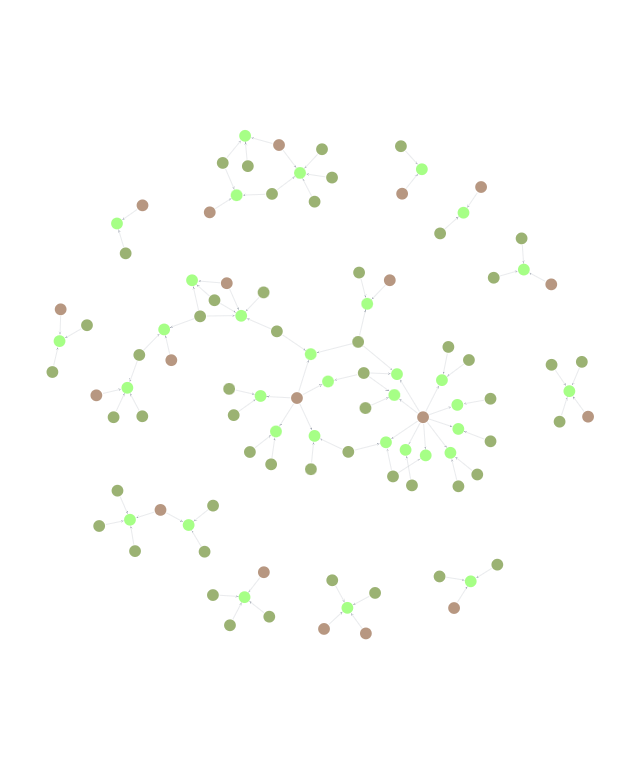

# Using LLM 

In [ ]:
llm = GoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=api_key) # if you are using Google API
#llm = OllamaLLM(model="llama3.2:latest")

In [40]:
node_structure = "\n".join([
    f"{col}: {', '.join(map(str, movies[col].unique()[:3]))}..." 
    for col in movies.columns
])
print(node_structure)

Release Year: 1907, 1908, 1909...
Title: Daniel boone, Laughing gas, The adventures of dollie...
Origin/Ethnicity: American...
Director: Wallace mccutcheon and ediwin s. porter, Edwin stanton porter, D. w. griffith...
Cast: William craven, florence lawrence, Bertha regustus, edward boulden, Arthur v. johnson, linda arvidson...
Genre: Biographical, Comedy, Drama...
Plot: Boone's daughter befriends an indian maiden as boone and his companion start out on a hunting expedition. while he is away, boone's cabin is attacked by the indians, who set it on fire and abduct boone's daughter. boone returns, swears vengeance, then heads out on the trail to the indian camp. his daughter escapes but is chased. the indians encounter boone, which sets off a huge fight on the edge of a cliff. a burning arrow gets shot into the indian camp. boone gets tied to the stake and tortured. the burning arrow sets the indian camp on fire, causing panic. boone is rescued by his horse, and boone has a knife fight in

In [41]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def validate_node_definition(node_def: Dict) -> bool:
    """Validate node definition structure"""
    if not isinstance(node_def, dict):
        return False
    return all(
        isinstance(v, dict) and all(isinstance(k, str) for k in v.keys())
        for v in node_def.values()
    )

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def get_node_definitions(chain, structure: str, example: Dict) -> Dict[str, Dict[str, str]]:
    """Get node definitions with retry logic"""
    try:
        # Get response from LLM
        response = chain.invoke({"structure": structure, "example": example})
        
        # Parse response
        node_defs = ast.literal_eval(response)
        
        # Validate structure
        if not validate_node_definition(node_defs):
            raise ValueError("Invalid node definition structure")
            
        return node_defs
        
    except (ValueError, SyntaxError) as e:
        logger.error(f"Error parsing node definitions: {e}")
        raise

# Updated node definition template
node_example = {
    "NodeLabel1": {"property1": "row['property1']", "property2": "row['property2']"},
    "NodeLabel2": {"property1": "row['property1']", "property2": "row['property2']"},
    "NodeLabel3": {"property1": "row['property1']", "property2": "row['property2']"},
}

define_nodes_prompt = PromptTemplate(
    input_variables=["example", "structure"],
    template=("""
        Analyze the dataset structure below and extract the entity labels for nodes and their properties.\n
        The node properties should be based on the dataset columns and their values.\n
        Return the result as a dictionary where the keys are the node labels and the values are the node properties.\n\n
        Example: {example}\n\n
        
        Dataset Structure:\n{structure}\n\n
              
        Make sure to include all the possible node labels and their properties.\n
        If a property can be its own node, include it as a separate node label.\n
        Please do not report triple backticks to identify a code block, just return the list of tuples.\n
        Return only the dictionary containing node labels and properties, and don't include any other text or quotation.
        
        """
    ),
)

# Execute with error handling
try:
    node_chain = define_nodes_prompt | llm

    node_definitions = get_node_definitions(node_chain, structure=node_structure, example=node_example)
    logger.info(f"Node Definitions: {node_definitions}")
except Exception as e:
    logger.error(f"Failed to get node definitions: {e}")
    raise

INFO:__main__:Node Definitions: {'Movie': {'Release Year': "row['Release Year']", 'Title': "row['Title']", 'Plot': "row['Plot']"}, 'Director': {'Name': "row['Director']"}, 'Cast': {'Name': "row['Cast']"}, 'Genre': {'Genre': "row['Genre']"}, 'Origin/Ethnicity': {'Origin/Ethnicity': "row['Origin/Ethnicity']"}}


In [49]:
class RelationshipIdentifier:
    """Identifies relationships between nodes in a graph database."""
    
    RELATIONSHIP_EXAMPLE = [
        ("NodeLabel1", "RelationshipLabel", "NodeLabel2"),
        ("NodeLabel1", "RelationshipLabel", "NodeLabel3"),
        ("NodeLabel2", "RelationshipLabel", "NodeLabel3"),
    ]


    PROMPT_TEMPLATE = PromptTemplate(
    input_variables=["structure", "node_definitions", "example"],
    template="""
        Consider the following Dataset Structure:\n{structure}\n\n

        Consider the following Node Definitions:\n{node_definitions}\n\n

        Based on the dataset structure and node definitions, identify relationships (edges) between nodes.\n
        Return the relationships as a list of triples where each triple contains the start node label, relationship label, and end node label, and each triple is a tuple.\n
        Please return only the list of tuples. Please do not report triple backticks to identify a code block, just return the list of tuples.\n\n

        Example:\n{example}
        """
)

    def __init__(self, llm: Any, logger: logging.Logger = None):
        self.llm = llm
        self.logger = logger or logging.getLogger(__name__)
        self.chain = self.PROMPT_TEMPLATE | self.llm

    def validate_relationships(self, relationships: List[Tuple]) -> bool:
        """Validate relationship structure."""
        return all(
            isinstance(rel, tuple) and 
            len(rel) == 3 and 
            all(isinstance(x, str) for x in rel)
            for rel in relationships
        )

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def identify_relationships(self, structure: str, node_definitions: Dict) -> List[Tuple]:
        """Identify relationships with retry logic."""
        try:
            response = self.chain.invoke({
                "structure": structure, 
                "node_definitions": str(node_definitions), 
                "example": str(self.RELATIONSHIP_EXAMPLE)
            })
            
            relationships = ast.literal_eval(response)
            
            if not self.validate_relationships(relationships):
                raise ValueError("Invalid relationship structure")
                
            self.logger.info(f"Identified {len(relationships)} relationships")
            return relationships
            
        except Exception as e:
            self.logger.error(f"Error identifying relationships: {e}")
            raise

    def get_relationship_types(self) -> List[str]:
        """Extract unique relationship types."""
        return list(set(rel[1] for rel in self.identify_relationships()))

# Usage
identifier = RelationshipIdentifier(llm=llm)
relationships = identifier.identify_relationships(node_structure, node_definitions)
print("Relationships:", relationships)

INFO:__main__:Identified 4 relationships


Relationships: [('Movie', 'HAS_DIRECTOR', 'Director'), ('Movie', 'HAS_CAST', 'Cast'), ('Movie', 'HAS_GENRE', 'Genre'), ('Movie', 'HAS_ORIGIN/ETHNICITY', 'Origin/Ethnicity')]


In [52]:
class CypherQueryBuilder:
    """Builds Cypher queries for Neo4j graph database."""

    INPUT_EXAMPLE = """
    NodeLabel1: value1, value2
    NodeLabel2: value1, value2
    """
    
    EXAMPLE_CYPHER = example_cypher = """
    CREATE (n1:NodeLabel1 {property1: "row['property1']", property2: "row['property2']"})
    CREATE (n2:NodeLabel2 {property1: "row['property1']", property2: "row['property2']"})
    CREATE (n1)-[:RelationshipLabel]->(n2);
    """

    PROMPT_TEMPLATE = PromptTemplate(
    input_variables=["structure", "node_definitions", "relationships", "example"],
    template="""
        Consider the following Node Definitions:\n{node_definitions}\n\n
        Consider the following Relationships:\n{relationships}\n\n
        Generate Cypher queries to create nodes and relationships using the node definitions and relationships below. Remember to replace the placeholder values with actual data from the dataset.\n
        Include all the properties in the Node Definitions for each node as defined and create relationships.\n
        Return a single string with each query separated by a semicolon.\n
        Don't include any other text or quotation marks in the response.\n
        Please return only the string containing Cypher queries. Please do not report triple backticks to identify a code block.\n\n

        Example Input:\n{input}\n\n

        Example Output Cypher query:\n{cypher}
    """
)

    def __init__(self, llm: Any, logger: logging.Logger = None):
        self.llm = llm
        self.logger = logger or logging.getLogger(__name__)
        # self.chain = LLMChain(llm=llm, prompt=self.PROMPT_TEMPLATE)
        self.chain = self.PROMPT_TEMPLATE | self.llm

    def validate_cypher_query(self, query: str) -> bool:
        """Validate Cypher query syntax using LLM and regex patterns."""
        
        VALIDATION_PROMPT = PromptTemplate(
            input_variables=["query"],
            template="""
            Validate this Cypher query and return TRUE or FALSE:
            
            Query: {query}
            
            Rules to check:
            1. Valid CREATE statements
            2. Proper property formatting
            3. Valid relationship syntax
            4. No missing parentheses
            5. Valid property names
            6. Valid relationship types
            
            Return only TRUE if query is valid, FALSE if invalid.
            """
        )
        
        try:
            # Basic pattern validation
            basic_valid = all(re.search(pattern, query) for pattern in [
                r'CREATE \(',  
                r'\{.*?\}',    
                r'\)-\[:.*?\]->'
            ])
            
            if not basic_valid:
                return False
                
            # LLM validation
            validation_chain = VALIDATION_PROMPT | self.llm
            result = validation_chain.invoke({"query": query})
            
            # Parse result
            is_valid = "TRUE" in result.upper()
            
            if not is_valid:
                self.logger.warning(f"LLM validation failed for query: {query}")
                
            return is_valid
            
        except Exception as e:
            self.logger.error(f"Validation error: {e}")
            return False

    def sanitize_query(self, query: str) -> str:
        """Sanitize and format Cypher query."""
        return (query
                .strip()
                .replace('\n', ' ')
                .replace('  ', ' ')
                .replace("'row[", "row['")
                .replace("]'", "']"))

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def build_queries(self, node_definitions: Dict, relationships: List) -> str:
        """Build Cypher queries with retry logic."""
        try:
            response = self.chain.invoke({
                "node_definitions": str(node_definitions),
                "relationships": str(relationships),
                "input": self.INPUT_EXAMPLE,
                "cypher": self.EXAMPLE_CYPHER
            })

            # Get response inside triple backticks
            if '```' in response:
                response = response.split('```')[1]

            
            # Sanitize response
            queries = self.sanitize_query(response)
            
            # Validate queries
            if not self.validate_cypher_query(queries):
                raise ValueError("Invalid Cypher query syntax")
                
            self.logger.info("Successfully generated Cypher queries")
            return queries
            
        except Exception as e:
            self.logger.error(f"Error building Cypher queries: {e}")
            raise

    def split_queries(self, queries: str) -> List[str]:
        """Split combined queries into individual statements."""
        return [q.strip() for q in queries.split(';') if q.strip()]

# Usage
builder = CypherQueryBuilder(llm=llm)
cypher_queries = builder.build_queries(node_definitions, relationships)
print("Cypher Queries:", cypher_queries)

INFO:__main__:Successfully generated Cypher queries


Cypher Queries: CREATE (m:Movie {Release Year: "row['Release Year']", Title: "row['Title']", Plot: "row['Plot']"}) CREATE (d:Director {Name: "row['Director']"}) CREATE (c:Cast {Name: "row['Cast']"}) CREATE (g:Genre {Genre: "row['Genre']"}) CREATE (o:Origin/Ethnicity {Origin/Ethnicity: "row['Origin/Ethnicity']"}) CREATE (m)-[:HAS_DIRECTOR]->(d) CREATE (m)-[:HAS_CAST]->(c) CREATE (m)-[:HAS_GENRE]->(g) CREATE (m)-[:HAS_ORIGIN/ETHNICITY]->(o);


In [54]:
logs = ""
total_rows = len(movies)

def sanitize_value(value):
    if isinstance(value, str):
        return value.replace('"', '')
    return str(value)

for index, row in tqdm(movies.iterrows(), 
                      total=total_rows,
                      desc="Loading data to Neo4j",
                      position=0,
                      leave=True):
    
    # Replace placeholders with actual values
    cypher_query = cypher_queries
    for column in movies.columns:
        cypher_query = cypher_query.replace(
            f"row['{column}']", 
            f'{sanitize_value(row[column])}'
        )
    
    try:
        # Execute query and update progress
        conn.execute_query(cypher_query)
    except Exception as e:
        logs += f"Error on row {index+1}: {str(e)}\n"

Loading data to Neo4j: 100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s]
